Good to add a disclaimer that this project is not sponsored by Airbnb



-Baseline Model - Dummy Classifier
-FSM - Something
(These are due next Tuesday)

MVP
-Presentation (Outline)
-Github
-Notebook



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


%matplotlib inline 

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("data/Airbnb_Data.csv")

df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [4]:
#At first glance, it seems as if there are no duplicates.

df['id'].value_counts()

11667455    1
1106505     1
11659752    1
20439529    1
4717034     1
           ..
6269649     1
1598886     1
9837993     1
7734698     1
13770756    1
Name: id, Length: 74111, dtype: int64

In [5]:
#Changing columns with dates as string to datetime

df['first_review'] = pd.to_datetime(df['first_review'])
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [6]:
print(df['first_review'].min())
print(df['first_review'].max())

2008-11-17 00:00:00
2017-10-05 00:00:00


In [7]:
print(df['host_since'].min())
print(df['host_since'].max())

2008-03-03 00:00:00
2017-10-04 00:00:00


In [8]:
print(df['last_review'].min())
print(df['last_review'].max())

2009-01-21 00:00:00
2017-10-05 00:00:00


A limitation of this dataset is that it seems a bit dated through end of 2017. It seems like the last date in the dataset is 2017-10-05. Using this value, we calculate the length of being a host.

In [9]:
last_date = df['last_review'].max()

In [10]:
#We have created a host experiences (in years) column

df['host_experience'] = [(last_date - date).days/365 for date in df['host_since']]

In [11]:
#We have the log_price but also good to create a price_per_night column

df['price_per_night'] = [np.exp(x) for x in df['log_price']]

In [12]:
#We need to combine the strict categories into one

df['cancellation_policy'].value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

In [13]:
#We have reclassified the super strict categories into just strict

df['cancellation_policy'] = df['cancellation_policy'].str.replace('super_strict_30', 'strict')
df['cancellation_policy'] = df['cancellation_policy'].str.replace('super_strict_60', 'strict')

In [14]:
df['cancellation_policy'].value_counts()

strict      32503
flexible    22545
moderate    19063
Name: cancellation_policy, dtype: int64

In [15]:
#We see some entries with null values for bedrooms and bathrooms

df[df['bedrooms'].isna()][['bedrooms', 'bathrooms']].head(20)

,bedrooms,bathrooms
200,NaN,1.0
301,NaN,1.0
2368,NaN,NaN
2842,NaN,NaN
3331,NaN,1.0
6647,NaN,1.0
7155,NaN,1.0
8807,NaN,1.0
10513,NaN,1.0
11584,NaN,1.0


In [16]:
#We will resort to dropping the null values in the bedrooms and bathrooms columns.
#We start with bathrooms because the column has more null values.

df.dropna(subset=['bathrooms'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73911 entries, 0 to 74110
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      73911 non-null  int64         
 1   log_price               73911 non-null  float64       
 2   property_type           73911 non-null  object        
 3   room_type               73911 non-null  object        
 4   amenities               73911 non-null  object        
 5   accommodates            73911 non-null  int64         
 6   bathrooms               73911 non-null  float64       
 7   bed_type                73911 non-null  object        
 8   cancellation_policy     73911 non-null  object        
 9   cleaning_fee            73911 non-null  bool          
 10  city                    73911 non-null  object        
 11  description             73911 non-null  object        
 12  first_review            58087 non-null  dateti

In [18]:
#Removing null values in the bathrooms category helped but there are still about 86 null values in the bedrooms column.
#We will also remove the null values in bedrooms

df.dropna(subset=['bedrooms'], inplace=True)

In [19]:
df['bedrooms_and_bathrooms'] = df['bedrooms'] + df['bathrooms']

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73825 entries, 0 to 74110
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      73825 non-null  int64         
 1   log_price               73825 non-null  float64       
 2   property_type           73825 non-null  object        
 3   room_type               73825 non-null  object        
 4   amenities               73825 non-null  object        
 5   accommodates            73825 non-null  int64         
 6   bathrooms               73825 non-null  float64       
 7   bed_type                73825 non-null  object        
 8   cancellation_policy     73825 non-null  object        
 9   cleaning_fee            73825 non-null  bool          
 10  city                    73825 non-null  object        
 11  description             73825 non-null  object        
 12  first_review            58019 non-null  dateti

In [21]:
df['city'].value_counts()

NYC        32205
LA         22360
SF          6413
DC          5672
Chicago     3716
Boston      3459
Name: city, dtype: int64

In [22]:
#We will be working with the Airbnb listings of that are only in NYC

df_nyc = df[df['city'] == 'NYC'].reset_index(drop=True)

In [23]:
df_nyc.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.531507,150.0,2.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0.295890,169.0,4.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.945205,145.0,2.0
3,5578513,4.605170,Apartment,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,2013-04-28,t,t,100%,2013-03-27,f,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,4.528767,100.0,2.0
4,17589436,4.882802,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,strict,True,NYC,"I am renting a very spacious, unique, bright L...",2015-09-26,t,t,71%,2015-08-17,f,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",Lower East Side,26,86.0,NaN,10002,1.0,2.0,2.136986,132.0,2.0


In [24]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32205 entries, 0 to 32204
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      32205 non-null  int64         
 1   log_price               32205 non-null  float64       
 2   property_type           32205 non-null  object        
 3   room_type               32205 non-null  object        
 4   amenities               32205 non-null  object        
 5   accommodates            32205 non-null  int64         
 6   bathrooms               32205 non-null  float64       
 7   bed_type                32205 non-null  object        
 8   cancellation_policy     32205 non-null  object        
 9   cleaning_fee            32205 non-null  bool          
 10  city                    32205 non-null  object        
 11  description             32205 non-null  object        
 12  first_review            25367 non-null  dateti

In [25]:
pd.set_option("display.max_rows", None)

df_nyc['neighbourhood'].value_counts()

Williamsburg                     2851
Bedford-Stuyvesant               2151
Bushwick                         1593
Upper West Side                  1389
Harlem                           1370
Hell's Kitchen                   1295
Upper East Side                  1201
Crown Heights                    1072
Astoria                           896
Lower East Side                   831
East Village                      810
East Harlem                       793
Chelsea                           721
Greenpoint                        720
Washington Heights                718
Hamilton Heights                  619
Alphabet City                     616
Clinton Hill                      611
West Village                      604
Park Slope                        599
Flatbush                          549
Midtown East                      440
Lefferts Garden                   340
Kips Bay                          333
Financial District                321
Midtown                           318
Chinatown   

In [26]:
bronx_neighbourhoods = ['Mott Haven', 'Concourse', 'Baychester', 'Soundview', 'Riverdale', 'Parkchester', 'Highbridge',
                       'Kingsbridge Heights', 'Bedford Park', 'Concourse Village', 'Bronxdale', 'Tremont', 'Wakefield',
                       'University Heights', 'Park Versailles', 'Kingsbridge', 'Claremont', 'Fordham', 'Eastchester',
                       'Norwood', 'Williamsbridge', 'Allerton', 'Pelham Bay', 'Port Morris', 'City Island',
                       'Crotona', 'Hunts Point', 'Morrisania', 'Morris Heights', 'Longwood', 'Throgs Neck', 'The Bronx',
                       'Melrose', 'Van Nest', 'Mount Eden', 'Castle Hill', 'Castle Hill ', 'Edenwald', 'Morris Park', 'Spuyten Duyvil',
                       'Belmont', 'West Farms', 'Co-op City', 'Woodlawn', 'Westchester Village', 'Country Club']
brooklyn_neighbourhoods = ['Williamsburg', 'Bedford-Stuyvesant', 'Bushwick', 'Crown Heights', 'Greenpoint',
                          'Clinton Hill', 'Park Slope', 'Flatbush', 'Lefferts Garden', 'Fort Greene',
                          'Prospect Heights', 'East Flatbush', 'Carroll Gardens', 'East New York',
                          'Boerum Hill', 'Sunset Park', 'Kensington', 'Windsor Terrace', 'Gowanus',
                          'Greenwood Heights', 'Brooklyn Heights', 'Bay Ridge', 'Downtown Brooklyn', 'Midwood',
                          'Sheepshead Bay', 'Canarsie', 'Brooklyn Navy Yard', 'Cobble Hill', 'Gravesend',
                          'Flatlands', 'Bensonhurst', 'Red Hook', 'DUMBO', 'Brownsville', 'Brighton Beach',
                          'Columbia Street Waterfront', 'Borough Park', 'Coney Island', 'Dyker Heights',
                          'Brooklyn', 'Bath Beach', 'Manhattan Beach', 'Sea Gate', 'Vinegar Hill', 'Bergen Beach',
                          'Marine Park', 'Gerritsen Beach', 'Mill Basin']
manhattan_neighbourhoods = ['Upper West Side', 'Harlem', "Hell's Kitchen", 'Upper East Side', 'Lower East Side',
                           'East Village', 'East Harlem', 'Chelsea', 'Washington Heights', 'Hamilton Heights',
                           'Alphabet City', 'West Village', 'Midtown East', 'Kips Bay', 'Financial District', 
                            'Midtown', 'Chinatown', 'Greenwich Village', 'Morningside Heights', 'Soho',
                           'Gramercy Park', 'Nolita', 'Murray Hill', 'Flatiron District', 
                            'Times Square/Theatre District', 'Inwood', 'Tribeca', 'Union Square', 'Noho', 
                            'Hudson Square', 'Battery Park City', 'Little Italy', 'Meatpacking District', 
                            'Civic Center', 'Manhattan', 'South Street Seaport', 'Marble Hill']
queens_neighbourhoods = ['Astoria', 'Jamaica', 'Ridgewood', 'Sunnyside', 'Flushing', 'Jackson Heights', 
                         'Long Island City', 'Elmhurst', 'Ditmars / Steinway', 'The Rockaways', 'Forest Hills',
                        'Woodside', 'Richmond Hill', 'Roosevelt Island', 'Corona', 'Rego Park', 'Bayside',
                        'Woodhaven', 'Maspeth', 'Kew Garden Hills', 'East Elmhurst', 'Ozone Park', 'Middle Village',
                        'Glendale', 'South Ozone Park', 'College Point', 'Hillcrest', 'Utopia', 'Whitestone',
                        'Howard Beach', 'Lindenwood', 'Queens', 'Fresh Meadows']
staten_neighbourhoods = ['St. George', 'Stapleton', 'West Brighton', 'South Beach', 'Tompkinsville', 'Midland Beach',
                        'Elm Park', 'New Brighton', 'Rosebank', 'Great Kills', 'Westerleigh', 'Tottenville',
                        'Eltingville', 'Grasmere', 'Meiers Corners', 'Concord', 'Randall Manor', 'Port Richmond',
                        'Grymes Hill', 'Castleton Corners', 'New Springville', 'Fort Wadsworth', 'Huguenot',
                        'Mariners Harbor', 'Emerson Hill', 'Silver Lake', 'Graniteville', 'Arrochar', 'Rossville',
                        'Annadale', 'Todt Hill', 'Grant City', 'Lighthouse HIll', 'Oakwood', 'Dongan Hills',
                        'Clifton', 'New Dorp Beach', 'Willowbrook']

def find_neighbourhoods(neighbourhood):
    if isinstance(neighbourhood, str):
        if neighbourhood in bronx_neighbourhoods:
            return "Other"
        if neighbourhood in brooklyn_neighbourhoods:
            return "Brooklyn"
        if neighbourhood in manhattan_neighbourhoods:
            return "Manhattan"
        if neighbourhood in queens_neighbourhoods:
            return "Other"
        if neighbourhood in staten_neighbourhoods:
            return "Other"
    else:
        None
    pass    
    
df_nyc['boroughs'] = df_nyc['neighbourhood'].apply(find_neighbourhoods)

In [27]:
df_nyc[df_nyc['boroughs'].isna()]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs
12537,16429976,4.442651,Bed & Breakfast,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,1.0,Real Bed,flexible,False,NYC,"My place is good for couples, solo adventurers...",2016-10-03,t,f,0%,2016-05-31,f,2016-10-03,40.747266,-73.711750,Your Own Bed room in a Condo close to JFK,NaN,1,100.0,https://a0.muscache.com/im/pictures/152dd61b-0...,11004,1.0,1.0,1.347945,85.0,2.0,None
14658,14153586,4.007333,Apartment,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,flexible,True,NYC,Beautiful small apartment in Floral Park / Gle...,NaT,t,t,100%,2013-09-15,t,NaT,40.746693,-73.710126,"Beautiful Apt in NYC and Long Island, JFK, LGA",NaN,0,NaN,https://a0.muscache.com/im/pictures/9d618fd5-0...,11004.0,2.0,1.0,4.057534,55.0,3.0,None
20740,2146019,4.521789,House,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",1,1.5,Real Bed,strict,True,NYC,Located in a quiet suburban neighborhood Imma...,2017-02-24,t,f,100%,2016-03-31,f,2017-09-17,40.769783,-73.739151,Private Apartment Near NYC Airports,NaN,17,99.0,https://a0.muscache.com/im/pictures/5adba2a1-b...,11363.0,0.0,1.0,1.515068,92.0,1.5,None
22020,17978081,3.970292,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,1.0,Real Bed,moderate,True,NYC,Beautiful home this is room 1 of 3 private bed...,NaT,t,t,100%,2014-07-27,f,NaT,40.757773,-73.729489,Douglaston (apt 2) Room one,NaN,0,NaN,https://a0.muscache.com/im/pictures/b286b55e-8...,11362,1.0,1.0,3.194521,53.0,2.0,None
23645,2794725,4.905275,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,flexible,True,NYC,This apartment features a brand new sectional ...,NaT,t,t,100%,2017-01-05,t,NaT,40.718972,-74.039567,"Beautiful Views of Statue of Liberty, mins to ...",NaN,0,NaN,https://a0.muscache.com/im/pictures/80043240-b...,7302.0,1.0,2.0,0.747945,135.0,2.0,None
27779,169430,4.304065,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,1.0,Real Bed,moderate,True,NYC,Spacious 1 bedrooms Suite in lower level/Basem...,2015-09-27,t,f,100%,2015-09-16,t,2017-10-01,40.733515,-73.712992,"""Bloom of Floral Park"" Private 1 BR Suite",NaN,14,97.0,https://a0.muscache.com/im/pictures/107298008/...,11001,1.0,1.0,2.054795,74.0,2.0,None
28007,16769883,3.970292,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,1.0,Real Bed,moderate,True,NYC,Beautiful home this is room 2 of 3 private bed...,NaT,t,t,100%,2014-07-27,f,NaT,40.755731,-73.729305,Douglaston (apt2) Room 2,NaN,0,NaN,https://a0.muscache.com/im/pictures/58a0b7e2-e...,11362.0,1.0,1.0,3.194521,53.0,2.0,None
28053,13687532,5.010635,House,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",5,1.5,Real Bed,moderate,True,NYC,Rustic and comfortable country house in the ci...,2017-09-04,t,f,100%,2017-08-11,f,2017-09-17,40.771874,-73.740766,"Garden Oasis in Queens, NYC, 2 blocks from train.",NaN,2,100.0,https://a0.muscache.com/im/pictures/86127e8e-f...,11363.0,3.0,3.0,0.150685,150.0,4.5,None


In [28]:
df_nyc.dropna(subset=['boroughs'], inplace=True)

In [29]:
df_nyc['boroughs'].value_counts(dropna=False)

Manhattan    14860
Brooklyn     13359
Other         3978
Name: boroughs, dtype: int64

In [30]:
df_nyc['review_scores_rating'].value_counts()

100.0    7091
93.0     1721
96.0     1672
95.0     1555
97.0     1528
98.0     1485
90.0     1451
94.0     1194
80.0     1151
92.0      988
99.0      751
91.0      745
89.0      548
87.0      533
88.0      507
85.0      292
86.0      275
60.0      246
84.0      212
83.0      189
82.0      100
70.0       91
73.0       75
81.0       61
40.0       53
75.0       50
20.0       42
78.0       42
79.0       42
77.0       39
76.0       38
67.0       29
74.0       22
72.0       13
65.0       12
50.0       12
68.0       10
69.0        7
71.0        6
64.0        5
53.0        3
57.0        3
63.0        2
47.0        2
66.0        2
62.0        2
55.0        2
56.0        1
27.0        1
Name: review_scores_rating, dtype: int64

In [31]:
#observing null score ratings

df_nyc_nullscores = df_nyc[df_nyc['review_scores_rating'].isnull() == True][['host_since','number_of_reviews', 'last_review', 'review_scores_rating']]

In [32]:
#The vast majority of null scores have 0 or 1 reviews

df_nyc_nullscores['number_of_reviews'].value_counts()

0      6800
1       399
2        48
3        17
4         8
15        3
5         3
23        2
8         2
21        1
28        1
36        1
17        1
63        1
33        1
37        1
47        1
6         1
18        1
7         1
19        1
43        1
101       1
Name: number_of_reviews, dtype: int64

In [33]:
#It's important to understand though that there are listing with no review scores that had more than one review.

df_nyc_nullscores[df_nyc_nullscores['number_of_reviews'] > 1]

,host_since,number_of_reviews,last_review,review_scores_rating
597,2014-03-15,6,2017-01-01,NaN
1064,2013-04-22,2,2016-06-17,NaN
1351,2015-02-25,3,2016-03-15,NaN
1434,2011-05-24,2,2017-07-19,NaN
1482,2013-03-17,15,2017-09-13,NaN
1501,2013-05-25,2,2015-11-21,NaN
1947,2013-10-30,2,2016-03-13,NaN
2258,2012-04-23,2,2017-05-11,NaN
2384,2015-10-14,2,2015-12-16,NaN
2457,2015-01-09,36,2017-09-07,NaN


It is difficult to tell why there are no review scores associated with listings with more than 1 review. However, these listings could be associated with suspended listings. 

"Airbnb has a strict policy on banning hosts who violate their community standards or terms of service. The company reserves the right to remove a host's listing and suspend or terminate their account if they engage in behavior that is deemed inappropriate, including but not limited to discrimination, harassment, fraudulent activity, or unsafe or illegal conduct."

Given the lack of information about the reviews/ratings for newer listings and potential suspended listings, we remove them from the dataset??????????


Or do we keep them in the dataset and assign a value ?????????

We'll come back to this

For those with no review - we will assign them the mean score
For those with more than 1 review but no review score - we will assume that the host lost credibility


In [34]:
# Calculate the mean rating
mean_rating = df_nyc['review_scores_rating'].mean()

# Create a boolean mask to identify rows with null values and number_of_reviews <= 1
mask = (df_nyc['review_scores_rating'].isnull()) & (df_nyc['number_of_reviews'] <= 1)

# Replace null values that meet the conditions with the mean rating
df_nyc.loc[mask, 'review_scores_rating'] = mean_rating

# Replace other null values with 0
df_nyc['review_scores_rating'].fillna(0, inplace=True)

In [35]:
df_nyc['review_scores_rating'].value_counts()

93.511987     7199
100.000000    7091
93.000000     1721
96.000000     1672
95.000000     1555
97.000000     1528
98.000000     1485
90.000000     1451
94.000000     1194
80.000000     1151
92.000000      988
99.000000      751
91.000000      745
89.000000      548
87.000000      533
88.000000      507
85.000000      292
86.000000      275
60.000000      246
84.000000      212
83.000000      189
82.000000      100
0.000000        97
70.000000       91
73.000000       75
81.000000       61
40.000000       53
75.000000       50
20.000000       42
78.000000       42
79.000000       42
77.000000       39
76.000000       38
67.000000       29
74.000000       22
72.000000       13
65.000000       12
50.000000       12
68.000000       10
69.000000        7
71.000000        6
64.000000        5
53.000000        3
57.000000        3
63.000000        2
47.000000        2
66.000000        2
62.000000        2
55.000000        2
56.000000        1
27.000000        1
Name: review_scores_rating, dty

In [36]:
#We will create a new column review_scores_rating_percentile

df_nyc['review_scores_rating_percentile'] = stats.rankdata(df_nyc['review_scores_rating'], method='average') / len(df_nyc)

In [37]:
#The amenities column needs a lot of cleaning up.

df_nyc['amenities'][0]

'{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'

In [38]:
#Cleaning up column to remove {} and ""

df_nyc['amenities'] = df_nyc['amenities'].str.replace('{', '').str.replace('}', '').str.replace('"', '')

In [39]:
df_nyc['amenities'][0]

'Wireless Internet,Air conditioning,Kitchen,Heating,Family/kid friendly,Essentials,Hair dryer,Iron,translation missing: en.hosting_amenity_50'

In [40]:
#First we will look at how many unique amenities exist

# Step 1: Extract the 'amenities' column
amenities_column = df_nyc['amenities']

# Step 2: Create an empty set
unique_amenities = set()

# Step 3: Iterate over each row
for row in amenities_column:
    # Step 4: Split the string value by commas
    amenities_list = row.split(',')

    # Step 5: Iterate over each amenity
    for amenity in amenities_list:
        # Step 6: Remove leading and trailing spaces
        cleaned_amenity = amenity.strip()

        # Step 7: Add the cleaned amenity to the set
        unique_amenities.add(cleaned_amenity)

# Step 8: Print the unique amenities
print(unique_amenities)

{'', 'Firm mattress', 'Air purifier', 'Lock on bedroom door', 'Babysitter recommendations', 'BBQ grill', 'Baby monitor', 'Air conditioning', 'Suitable for events', 'Wide clearance to bed', 'Cable TV', 'Stair gates', 'Wide clearance to shower & toilet', 'Refrigerator', 'Smoking allowed', 'Indoor fireplace', 'translation missing: en.hosting_amenity_50', 'Washer / Dryer', 'Iron', 'Ground floor access', 'Patio or balcony', 'Pets live on this property', 'EV charger', 'Bed linens', 'Self Check-In', 'Lockbox', 'Ski in/Ski out', 'Free parking on street', 'Hot water kettle', 'translation missing: en.hosting_amenity_49', 'Safety card', 'Flat', 'Cat(s)', 'Waterfront', 'Host greets you', 'Cooking basics', 'Dog(s)', 'Kitchen', 'Hot tub', 'Free parking on premises', 'Room-darkening shades', 'Game console', 'Pocket wifi', 'Wide hallway clearance', 'Accessible-height toilet', 'Roll-in shower with chair', 'Pool', 'Luggage dropoff allowed', 'Dishes and silverware', 'First aid kit', 'Breakfast', 'Well-li

In [41]:
#Have identified 118 unique amenities but the output needs some cleaning

len(unique_amenities)

117

In [42]:
#We are cleaning up the Unique Amenities
unique_amenities.remove('')
unique_amenities.remove('translation missing: en.hosting_amenity_49')
unique_amenities.remove('translation missing: en.hosting_amenity_50')

In [43]:
len(unique_amenities)

114

In [44]:
unique_amenities_list = sorted(unique_amenities)

In [45]:
unique_amenities_list

['24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Free parking on premises',
 'Free parking on street',
 'Game console',
 'Garden or backyard',
 'Ground floor access',
 '

In [46]:
#Now we create an amenities_count column to figure out how many amenities exist for each listing
df_nyc['amenities_count'] = 0
row_count = 0

for row in df_nyc['amenities']:
    amenities_list = row.split(',')
    cleaned_list = []
    count = 0

    for amenity in amenities_list:
        cleaned_amenity = amenity.strip()
        cleaned_list.append(cleaned_amenity)

    for amenity in cleaned_list:
        if amenity in unique_amenities_list:
            count += 1

    df_nyc.loc[row_count, 'amenities_count'] = count
    row_count += 1

In [47]:
#Checking if the amenities_count was done correctly

df_nyc[['amenities','amenities_count']].head()

,amenities,amenities_count
0,"Wireless Internet,Air conditioning,Kitchen,Hea...",8.0
1,"Wireless Internet,Air conditioning,Kitchen,Hea...",14.0
2,"TV,Cable TV,Wireless Internet,Air conditioning...",18.0
3,"Internet,Wireless Internet,Air conditioning,Ki...",14.0
4,"TV,Cable TV,Internet,Wireless Internet,Air con...",18.0


In [48]:
#We have eight unique amenities excluding the last value that doesn't tell us anything. The count is working correctly.

df_nyc['amenities'][0]

'Wireless Internet,Air conditioning,Kitchen,Heating,Family/kid friendly,Essentials,Hair dryer,Iron,translation missing: en.hosting_amenity_50'

In [49]:
#

df_nyc['amenities_count'].value_counts().head(20)

13.0    2303
14.0    2293
12.0    2198
15.0    2182
16.0    2089
11.0    1898
17.0    1844
10.0    1792
18.0    1672
19.0    1487
9.0     1433
20.0    1299
8.0     1153
21.0    1030
22.0     891
7.0      882
23.0     728
6.0      548
24.0     547
25.0     409
Name: amenities_count, dtype: int64

-Explored but might not be necessary....

We need to narrow down the unique amenities to figure out which ones are amenities that guests want

-https://www.airbnb.com/resources/hosting-homes/a/the-amenities-guests-want-25
-https://www.superhog.com/blog/must-have-airbnb-amenities/

Airbnb commissioned a survey of 8,629 individuals across the US, Canada, Australia, China, Mexico, Brazil, India, Germany, Spain, Argentina and Italy ages 18 and over via Pollfish in July 2018 to better understand what amenities modern travelers crave most and how they differ by location and age
-https://news.airbnb.com/amenities-do-matter-airbnb-reveals-which-amenities-guests-search-for-most/

Total Amenities (Count)
Desired Amenities

In [50]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32205 entries, 0 to 28053
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               32197 non-null  float64       
 1   log_price                        32197 non-null  float64       
 2   property_type                    32197 non-null  object        
 3   room_type                        32197 non-null  object        
 4   amenities                        32197 non-null  object        
 5   accommodates                     32197 non-null  float64       
 6   bathrooms                        32197 non-null  float64       
 7   bed_type                         32197 non-null  object        
 8   cancellation_policy              32197 non-null  object        
 9   cleaning_fee                     32197 non-null  object        
 10  city                             32197 non-null  object   

We will now work on developing a host reliability score. We will use the following columns to construct such column:
- host_has_profile_pic
- host_identity_verified
- host_response_rate
- host_experience

The host reliability score will be created using an equal weighting of each column to come up with a score.
- 25% x host_has_profile_pic + 25% x host_identity_verified + 25% x host_response_rate + 25% x host_experience_percentile

To start we will start by cleaning up the host_has_profile_pic and host_identify_verified columns, which has 't' and 'f' as values. We will convert these into 1 and 0, respectively.

In [51]:
df_nyc['host_has_profile_pic'] = df_nyc['host_has_profile_pic'].replace({'t': 1, 'f': 0})
df_nyc['host_identity_verified'] = df_nyc['host_identity_verified'].replace({'t': 1, 'f': 0})

In [52]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32205 entries, 0 to 28053
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               32197 non-null  float64       
 1   log_price                        32197 non-null  float64       
 2   property_type                    32197 non-null  object        
 3   room_type                        32197 non-null  object        
 4   amenities                        32197 non-null  object        
 5   accommodates                     32197 non-null  float64       
 6   bathrooms                        32197 non-null  float64       
 7   bed_type                         32197 non-null  object        
 8   cancellation_policy              32197 non-null  object        
 9   cleaning_fee                     32197 non-null  object        
 10  city                             32197 non-null  object   

In [53]:
#We move on to cleaning up the host_response_rate, which consists of a good amount of null values

df_nyc[df_nyc['host_response_rate'].isna()][['host_response_rate','number_of_reviews']].head(5)

#What we can see is that host_response_rate is not necessarily because the hosts are new.
#It is more likely that the null values in the host_response_rate are associated with no responses.

,host_response_rate,number_of_reviews
0,NaN,2.0
14,NaN,0.0
17,NaN,0.0
19,NaN,1.0
23,NaN,0.0


In [54]:
df_nyc['host_response_rate'].value_counts()

100%    17168
90%      1089
80%       576
0%        388
50%       301
70%       247
67%       202
75%       186
60%       181
89%       139
88%       126
83%       125
86%       117
97%       109
92%       106
93%       102
94%        99
95%        98
33%        72
96%        71
91%        69
40%        68
98%        62
99%        55
78%        40
71%        39
25%        39
63%        33
57%        31
82%        31
30%        23
20%        20
87%        18
73%        16
74%        15
79%        15
43%        13
29%        13
84%        13
56%        13
85%        12
81%        11
77%        11
55%        10
44%        10
76%         9
17%         9
64%         9
69%         8
38%         7
46%         7
58%         6
10%         6
68%         4
53%         4
26%         3
65%         3
22%         3
35%         2
36%         2
47%         2
66%         2
59%         2
54%         2
14%         2
52%         1
27%         1
41%         1
15%         1
21%         1
61%         1
72%   

In [55]:
#For the null values, we assign 0% to hosts with null value response rates.
#However, this column is currently an object. As such, we change the column into a type float

df_nyc['host_response_rate'].fillna('0%', inplace=True)
df_nyc['host_response_rate'] = df_nyc['host_response_rate'].str.rstrip('%').astype(float) / 100

In [56]:
df_nyc.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs,review_scores_rating_percentile,amenities_count
0,6901257.0,5.010635,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",3.0,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1.0,1.0,0.00,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2.0,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.531507,150.0,2.0,Brooklyn,0.889897,8.0
1,6304928.0,5.129899,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",7.0,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,1.0,0.0,1.00,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6.0,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0.295890,169.0,4.0,Manhattan,0.275243,14.0
2,7919400.0,4.976734,Apartment,Entire home/apt,"TV,Cable TV,Wireless Internet,Air conditioning...",5.0,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,1.0,1.0,1.00,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10.0,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.945205,145.0,2.0,Manhattan,0.233174,18.0
3,5578513.0,4.605170,Apartment,Private room,"Internet,Wireless Internet,Air conditioning,Ki...",2.0,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,2013-04-28,1.0,1.0,1.00,2013-03-27,f,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82.0,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,4.528767,100.0,2.0,Manhattan,0.275243,14.0
4,17589436.0,4.882802,Apartment,Entire home/apt,"TV,Cable TV,Internet,Wireless Internet,Air con...",2.0,1.0,Real Bed,strict,True,NYC,"I am renting a very spacious, unique, bright L...",2015-09-26,1.0,1.0,0.71,2015-08-17,f,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",Lower East Side,26.0,86.0,NaN,10002,1.0,2.0,2.136986,132.0,2.0,Manhattan,0.096034,18.0


In [57]:
#Finally, we take a look at host experience. We first check for any null values

df_nyc[df_nyc['host_experience'].isna()][['id','number_of_reviews','host_experience']]

,id,number_of_reviews,host_experience
35,262343.0,0.0,NaN
47,4588783.0,7.0,NaN
83,18058045.0,6.0,NaN
235,20973084.0,0.0,NaN
249,15629616.0,7.0,NaN
594,5213291.0,39.0,NaN
848,19926959.0,5.0,NaN
955,528357.0,1.0,NaN
1059,6196354.0,1.0,NaN
1210,18045794.0,6.0,NaN


In [58]:
#We see that these values are not available and it is not because the hosts are new.
#Given that it is only 176 rows, we will resort to dropping

df_nyc.dropna(subset=['host_experience'], inplace=True)

In [59]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32022 entries, 0 to 32204
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               32022 non-null  float64       
 1   log_price                        32022 non-null  float64       
 2   property_type                    32022 non-null  object        
 3   room_type                        32022 non-null  object        
 4   amenities                        32022 non-null  object        
 5   accommodates                     32022 non-null  float64       
 6   bathrooms                        32022 non-null  float64       
 7   bed_type                         32022 non-null  object        
 8   cancellation_policy              32022 non-null  object        
 9   cleaning_fee                     32022 non-null  object        
 10  city                             32022 non-null  object   

In [60]:
#We now create a new column host_experience_percentile, which is the percentile ranking of the host experience
df_nyc['host_experience_percentile'] = stats.rankdata(df_nyc['host_experience'], method='average') / len(df_nyc)


In [61]:
df_nyc.head(20)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs,review_scores_rating_percentile,amenities_count,host_experience_percentile
0,6901257.0,5.010635,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",3.0,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1.0,1.0,0.00,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2.0,100.000000,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.531507,150.0,2.0,Brooklyn,0.889897,8.0,0.872322
1,6304928.0,5.129899,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",7.0,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,1.0,0.0,1.00,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6.0,93.000000,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0.295890,169.0,4.0,Manhattan,0.275243,14.0,0.038317
2,7919400.0,4.976734,Apartment,Entire home/apt,"TV,Cable TV,Wireless Internet,Air conditioning...",5.0,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,1.0,1.0,1.00,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10.0,92.000000,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.945205,145.0,2.0,Manhattan,0.233174,18.0,0.112719
3,5578513.0,4.605170,Apartment,Private room,"Internet,Wireless Internet,Air conditioning,Ki...",2.0,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,2013-04-28,1.0,1.0,1.00,2013-03-27,f,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82.0,93.000000,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,4.528767,100.0,2.0,Manhattan,0.275243,14.0,0.745238
4,17589436.0,4.882802,Apartment,Entire home/apt,"TV,Cable TV,Internet,Wireless Internet,Air con...",2.0,1.0,Real Bed,strict,True,NYC,"I am renting a very spacious, unique, bright L...",2015-09-26,1.0,1.0,0.71,2015-08-17,f,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",Lower East Side,26.0,86.000000,NaN,10002,1.0,2.0,2.136986,132.0,2.0,Manhattan,0.096034,18.0,0.323918
5,18224863.0,4.595120,House,Entire home/apt,"TV,Wireless Internet,Air conditioning,Kitchen,...",8.0,1.0,Real Bed,strict,True,NYC,"Huge 3 bedroom apartment situated in Flatbush,...",2017-07-30,1.0,0.0,1.00,2017-05-09,t,2017-09-15,40.643773,-73.950855,3 Bedroom Apartment for Small Group or Family,Flatbush,5.0,72.000000,https://a0.muscache.com/im/pictures/e9baba99-e...,11226.0,3.0,3.0,0.408219,99.0,4.0,Brooklyn,0.019722,24.0,0.054166
6,16679342.0,3.688879,House,Private room,"Internet,Air conditioning,Kitchen,Smoking allo...",2.0,1.5,Real Bed,strict,True,NYC,Cozy room in my big private house in Brooklyn....,2015-10-10,1.0,1.0,1.00,2014-08-27,f,2017-09-22,40.656278,-73.922645,THE LIBRARY LOUNGE,East Flatbush,57.0,89.000000,https://a0.muscache.com/im/pictures/58fcc67e-4...,11212.0,1.0,1.0,3.109589,40.0,2.5,Brooklyn,0.141116,9.0,0.505012
7,14122244.0,5.003946,Apartment,Entire home/apt,"TV,Cable TV,Internet,Wireless Internet,Air con...",6.0,1.0,Real Bed,strict,True,NYC,"My place is close to JFK Airport, Green Acres ...",2017-03-25,1.0,1.0,1.00,2017-01-10,f,2017-09-24,40.692057,-73.745464,JFK LUXURIOUS APARTMENT,Jamaica,14.0,100.000000,https://a0.muscache.com/im/pictures/095186d9-1...,11411.0,3.0,3.0,0.734247,149.0,4.0,Other,0.889897,44.0,0.086878
8,14490881.0,5.003946,Apartment,Entire home/apt,"TV,Cable TV,Wireless Internet,Air conditioning...",4.0,1.0,Real Bed,strict,True,NYC,This beautiful

In [62]:
#We are now ready to create our host_reliability_score column
#25% x host_has_profile_pic + 25% x host_identity_verified + 25% x host_response_rate + 25% x host_experience_percentile

weights = [0.25, 0.25, 0.25, 0.25]

df_nyc['host_reliability_score'] = np.average(df_nyc[['host_has_profile_pic', 
                                                      'host_identity_verified', 
                                                      'host_response_rate',
                                                      'host_experience_percentile']],
                                              axis=1,
                                              weights=weights
                                             )

In [63]:
#We now create a new column host_experience_percentile, which is the percentile ranking of the host experience
df_nyc['host_reliability_score_percentile'] = stats.rankdata(df_nyc['host_reliability_score'],
                                                             method='average') / len(df_nyc)

In [64]:
df_nyc.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs,review_scores_rating_percentile,amenities_count,host_experience_percentile,host_reliability_score,host_reliability_score_percentile
0,6901257.0,5.010635,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",3.0,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1.0,1.0,0.00,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2.0,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.531507,150.0,2.0,Brooklyn,0.889897,8.0,0.872322,0.718081,0.514693
1,6304928.0,5.129899,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",7.0,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,1.0,0.0,1.00,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6.0,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0.295890,169.0,4.0,Manhattan,0.275243,14.0,0.038317,0.509579,0.184077
2,7919400.0,4.976734,Apartment,Entire home/apt,"TV,Cable TV,Wireless Internet,Air conditioning...",5.0,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,1.0,1.0,1.00,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10.0,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.945205,145.0,2.0,Manhattan,0.233174,18.0,0.112719,0.778180,0.585644
3,5578513.0,4.605170,Apartment,Private room,"Internet,Wireless Internet,Air conditioning,Ki...",2.0,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,2013-04-28,1.0,1.0,1.00,2013-03-27,f,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82.0,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,4.528767,100.0,2.0,Manhattan,0.275243,14.0,0.745238,0.936309,0.872369
4,17589436.0,4.882802,Apartment,Entire home/apt,"TV,Cable TV,Internet,Wireless Internet,Air con...",2.0,1.0,Real Bed,strict,True,NYC,"I am renting a very spacious, unique, bright L...",2015-09-26,1.0,1.0,0.71,2015-08-17,f,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",Lower East Side,26.0,86.0,NaN,10002,1.0,2.0,2.136986,132.0,2.0,Manhattan,0.096034,18.0,0.323918,0.758479,0.563050


In [65]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32022 entries, 0 to 32204
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   id                                 32022 non-null  float64       
 1   log_price                          32022 non-null  float64       
 2   property_type                      32022 non-null  object        
 3   room_type                          32022 non-null  object        
 4   amenities                          32022 non-null  object        
 5   accommodates                       32022 non-null  float64       
 6   bathrooms                          32022 non-null  float64       
 7   bed_type                           32022 non-null  object        
 8   cancellation_policy                32022 non-null  object        
 9   cleaning_fee                       32022 non-null  object        
 10  city                              

In [66]:
#We now create a new column log_price_percentile, which is the percentile ranking of log_price column
df_nyc['log_price_percentile'] = stats.rankdata(df_nyc['log_price'], method='average') / len(df_nyc)

In [67]:
df_nyc.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs,review_scores_rating_percentile,amenities_count,host_experience_percentile,host_reliability_score,host_reliability_score_percentile,log_price_percentile
0,6901257.0,5.010635,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",3.0,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,1.0,1.0,0.00,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2.0,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.531507,150.0,2.0,Brooklyn,0.889897,8.0,0.872322,0.718081,0.514693,0.683077
1,6304928.0,5.129899,Apartment,Entire home/apt,"Wireless Internet,Air conditioning,Kitchen,Hea...",7.0,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,1.0,0.0,1.00,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6.0,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,0.295890,169.0,4.0,Manhattan,0.275243,14.0,0.038317,0.509579,0.184077,0.735213
2,7919400.0,4.976734,Apartment,Entire home/apt,"TV,Cable TV,Wireless Internet,Air conditioning...",5.0,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,1.0,1.0,1.00,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10.0,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0,0.945205,145.0,2.0,Manhattan,0.233174,18.0,0.112719,0.778180,0.585644,0.650084
3,5578513.0,4.605170,Apartment,Private room,"Internet,Wireless Internet,Air conditioning,Ki...",2.0,1.0,Real Bed,strict,True,NYC,This is a bright bedroom in an historic buildi...,2013-04-28,1.0,1.0,1.00,2013-03-27,f,2016-11-15,40.723883,-73.983880,Large East Village Bedroom To Let!,Alphabet City,82.0,93.0,https://a0.muscache.com/im/pictures/21726900/1...,10009.0,1.0,1.0,4.528767,100.0,2.0,Manhattan,0.275243,14.0,0.745238,0.936309,0.872369,0.471535
4,17589436.0,4.882802,Apartment,Entire home/apt,"TV,Cable TV,Internet,Wireless Internet,Air con...",2.0,1.0,Real Bed,strict,True,NYC,"I am renting a very spacious, unique, bright L...",2015-09-26,1.0,1.0,0.71,2015-08-17,f,2016-12-12,40.719086,-73.990285,"Amazing LES apt - cool, bright...",Lower East Side,26.0,86.0,NaN,10002,1.0,2.0,2.136986,132.0,2.0,Manhattan,0.096034,18.0,0.323918,0.758479,0.563050,0.617466


In [68]:
#After the feature engineering process, we are creating a new dataframe with organizing the relevant columns.

df_nyc_clean = df_nyc[['id',
                       'price_per_night',
                       'log_price',
                       'log_price_percentile', 
                       'neighbourhood',
                       'boroughs',
                       'property_type',
                       'room_type',
                       'bathrooms', 
                       'bedrooms',
                       'bedrooms_and_bathrooms',
                       'beds', 
                       'accommodates', 
                       'amenities_count', 
                       'number_of_reviews', 
                       'review_scores_rating', 
                       'review_scores_rating_percentile', 
                       'host_has_profile_pic', 
                       'host_identity_verified',
                       'host_response_rate',
                       'host_experience',
                       'host_experience_percentile', 
                       'host_reliability_score',
                       'host_reliability_score_percentile']]

In [69]:
df_nyc_clean.head()

,id,price_per_night,log_price,log_price_percentile,neighbourhood,boroughs,property_type,room_type,bathrooms,bedrooms,bedrooms_and_bathrooms,beds,accommodates,amenities_count,number_of_reviews,review_scores_rating,review_scores_rating_percentile,host_has_profile_pic,host_identity_verified,host_response_rate,host_experience,host_experience_percentile,host_reliability_score,host_reliability_score_percentile
0,6901257.0,150.0,5.010635,0.683077,Brooklyn Heights,Brooklyn,Apartment,Entire home/apt,1.0,1.0,2.0,1.0,3.0,8.0,2.0,100.0,0.889897,1.0,1.0,0.00,5.531507,0.872322,0.718081,0.514693
1,6304928.0,169.0,5.129899,0.735213,Hell's Kitchen,Manhattan,Apartment,Entire home/apt,1.0,3.0,4.0,3.0,7.0,14.0,6.0,93.0,0.275243,1.0,0.0,1.00,0.295890,0.038317,0.509579,0.184077
2,7919400.0,145.0,4.976734,0.650084,Harlem,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,3.0,5.0,18.0,10.0,92.0,0.233174,1.0,1.0,1.00,0.945205,0.112719,0.778180,0.585644
3,5578513.0,100.0,4.605170,0.471535,Alphabet City,Manhattan,Apartment,Private room,1.0,1.0,2.0,1.0,2.0,14.0,82.0,93.0,0.275243,1.0,1.0,1.00,4.528767,0.745238,0.936309,0.872369
4,17589436.0,132.0,4.882802,0.617466,Lower East Side,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,2.0,2.0,18.0,26.0,86.0,0.096034,1.0,1.0,0.71,2.136986,0.323918,0.758479,0.563050


In [70]:
#The code below is being used to turn off a warning that is not relevant during our feature engineering process.

pd.options.mode.chained_assignment = None  # default='warn'

In [71]:
#We are now ready to create our host_reliability_score column
#Experience_Score = .5 x review_scores_rating_percentile + .5 x host_reliability_score_percentile

weights = [0.5, 0.5]

df_nyc_clean['experience_score'] = np.average(df_nyc_clean[['review_scores_rating_percentile', 
                                                            'host_reliability_score_percentile']],
                                              axis=1,
                                              weights=weights
                                             )

In [72]:
#We will now do the final percentile based on experience score
df_nyc_clean['experience_score_percentile'] = stats.rankdata(df_nyc_clean['experience_score'], 
                                                             method='average') / len(df_nyc)

In [73]:
#Now we will assign the target variable - Experience Quality
#We assign numerical values for Bad, OK, and Good Qualities as 0, 1, 2, respectively.

for index, row in df_nyc_clean.iterrows():
    if row['experience_score_percentile'] <= (1/3):
        df_nyc_clean.loc[index, 'experience_quality'] = 0
    elif (row['experience_score_percentile'] > (1/3)) and (row['experience_score_percentile'] <= (2/3)):
        df_nyc_clean.loc[index, 'experience_quality'] = 1
    else:
        df_nyc_clean.loc[index, 'experience_quality'] = 2

In [74]:
df_nyc_clean.head()

,id,price_per_night,log_price,log_price_percentile,neighbourhood,boroughs,property_type,room_type,bathrooms,bedrooms,bedrooms_and_bathrooms,beds,accommodates,amenities_count,number_of_reviews,review_scores_rating,review_scores_rating_percentile,host_has_profile_pic,host_identity_verified,host_response_rate,host_experience,host_experience_percentile,host_reliability_score,host_reliability_score_percentile,experience_score,experience_score_percentile,experience_quality
0,6901257.0,150.0,5.010635,0.683077,Brooklyn Heights,Brooklyn,Apartment,Entire home/apt,1.0,1.0,2.0,1.0,3.0,8.0,2.0,100.0,0.889897,1.0,1.0,0.00,5.531507,0.872322,0.718081,0.514693,0.702295,0.801449,2.0
1,6304928.0,169.0,5.129899,0.735213,Hell's Kitchen,Manhattan,Apartment,Entire home/apt,1.0,3.0,4.0,3.0,7.0,14.0,6.0,93.0,0.275243,1.0,0.0,1.00,0.295890,0.038317,0.509579,0.184077,0.229660,0.111017,0.0
2,7919400.0,145.0,4.976734,0.650084,Harlem,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,3.0,5.0,18.0,10.0,92.0,0.233174,1.0,1.0,1.00,0.945205,0.112719,0.778180,0.585644,0.409409,0.350447,1.0
3,5578513.0,100.0,4.605170,0.471535,Alphabet City,Manhattan,Apartment,Private room,1.0,1.0,2.0,1.0,2.0,14.0,82.0,93.0,0.275243,1.0,1.0,1.00,4.528767,0.745238,0.936309,0.872369,0.573806,0.622307,1.0
4,17589436.0,132.0,4.882802,0.617466,Lower East Side,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,2.0,2.0,18.0,26.0,86.0,0.096034,1.0,1.0,0.71,2.136986,0.323918,0.758479,0.563050,0.329542,0.243583,0.0


In [75]:
#We have now created our target variable 'experience_quality'

df_nyc_clean['experience_quality'].value_counts(normalize=True)

1.0    0.333333
0.0    0.333333
2.0    0.333333
Name: experience_quality, dtype: float64

In [76]:
df_nyc_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32022 entries, 0 to 32204
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 32022 non-null  float64
 1   price_per_night                    32022 non-null  float64
 2   log_price                          32022 non-null  float64
 3   log_price_percentile               32022 non-null  float64
 4   neighbourhood                      32022 non-null  object 
 5   boroughs                           32022 non-null  object 
 6   property_type                      32022 non-null  object 
 7   room_type                          32022 non-null  object 
 8   bathrooms                          32022 non-null  float64
 9   bedrooms                           32022 non-null  float64
 10  bedrooms_and_bathrooms             32022 non-null  float64
 11  beds                               31990 non-null  flo

# Modeling

In [77]:
df_nyc_clean.dtypes

id                                   float64
price_per_night                      float64
log_price                            float64
log_price_percentile                 float64
neighbourhood                         object
boroughs                              object
property_type                         object
room_type                             object
bathrooms                            float64
bedrooms                             float64
bedrooms_and_bathrooms               float64
beds                                 float64
accommodates                         float64
amenities_count                      float64
number_of_reviews                    float64
review_scores_rating                 float64
review_scores_rating_percentile      float64
host_has_profile_pic                 float64
host_identity_verified               float64
host_response_rate                   float64
host_experience                      float64
host_experience_percentile           float64
host_relia

In [78]:
#Defining our X and y variables
# Independent variables - price_per_night, boroughs, bathrooms, bedrooms, amenities_count, number_of_reviews
# Dependent variable - experience quality

X = df_nyc_clean[['price_per_night', 'boroughs', 'bathrooms', 'bedrooms', 'amenities_count', 'number_of_reviews']]
y = df_nyc_clean['experience_quality']

In [79]:
#Conducting a train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100)

In [80]:
X.head()

,price_per_night,boroughs,bathrooms,bedrooms,amenities_count,number_of_reviews
0,150.0,Brooklyn,1.0,1.0,8.0,2.0
1,169.0,Manhattan,1.0,3.0,14.0,6.0
2,145.0,Manhattan,1.0,1.0,18.0,10.0
3,100.0,Manhattan,1.0,1.0,14.0,82.0
4,132.0,Manhattan,1.0,1.0,18.0,26.0


In [81]:
# Creating a Column Transformer for our preprocessing steps

CT = ColumnTransformer(transformers=[('ss', StandardScaler(), [0, 2, 3, 4, 5]), 
                                     ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), [1])],
                       remainder='passthrough')

### Creating Baseline Model

In [82]:
#We are adding our Baseline model - The Dummy Classifier

baseline_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('dummy', DummyClassifier(strategy='most_frequent'))])

In [83]:
baseline_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [84]:
baseline_model_pipe.score(X_train, y_train)

0.33456862091938705

In [85]:
baseline_model_pipe.score(X_test, y_test)

0.3296277791656258

### First Simple Model

In [86]:
#We are adding our first simple model (fsm) - Logistics Regression

fsm_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('logreg', LogisticRegression(multi_class='multinomial', 
                                                                   random_state=100))])

In [87]:
fsm_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('logreg',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=100))])

In [88]:
fsm_model_pipe.score(X_train, y_train)

0.41389073950699534

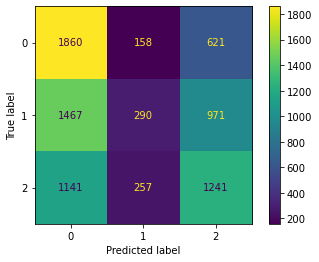

In [89]:
#Confusion Matrix of First Simple Model

y_pred_fsm = fsm_model_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_fsm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [90]:
fsm_model_pipe.score(X_test, y_test)

0.42355733200099926

In [91]:
accuracy_score(y_test, y_pred_fsm)

0.42355733200099926

In [92]:
precision_score(y_test, y_pred_fsm, labels=[0], average='micro')

0.41629364368845123

In [93]:
precision_score(y_test, y_pred_fsm, labels=[1], average='micro')

0.41134751773049644

In [94]:
precision_score(y_test, y_pred_fsm, labels=[2], average='micro')

0.4380515354747617

### Gridsearching

In [95]:
#Implementing Gridsearch to find best logistics regression parameters

parameters = {'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1],
             'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']}

gs = GridSearchCV(estimator=fsm_model_pipe,
                 param_grid=parameters,
                 cv=5)

In [96]:
gs.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1])])),
                                       ('logreg',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=100))]),
             param_grid={'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'sag']})

In [97]:
gs.best_params_

{'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}

### Best LogReg Model

In [98]:
#Using the best parameters from GridSearchCV to run best Logistics Regression model

best_logreg_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('best_logreg', LogisticRegression(multi_class='multinomial',
                                                                        C=0.1, 
                                                                        solver='lbfgs', 
                                                                        random_state=100))])

In [99]:
best_logreg_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('best_logreg',
                 LogisticRegression(C=0.1, multi_class='multinomial',
                                    random_state=100))])

In [100]:
best_logreg_model_pipe.score(X_train, y_train)

0.41389073950699534

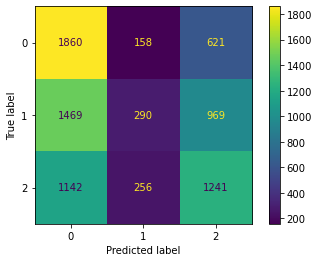

In [101]:
#Confusion Matrix of Best LogReg Model

y_pred_bestlog = best_logreg_model_pipe.predict(X_test)
cm_bestlog = confusion_matrix(y_test, y_pred_bestlog)

disp_bestlog = ConfusionMatrixDisplay(confusion_matrix=cm_bestlog)

disp_bestlog.plot();

In [102]:
best_logreg_model_pipe.score(X_test, y_test)

0.42355733200099926

In [103]:
accuracy_score(y_test, y_pred_bestlog)

0.42355733200099926

In [104]:
precision_score(y_test, y_pred_bestlog, labels=[0], average='micro')

0.41601431447103554

In [105]:
precision_score(y_test, y_pred_bestlog, labels=[1], average='micro')

0.4119318181818182

In [106]:
precision_score(y_test, y_pred_bestlog, labels=[2], average='micro')

0.43836100317908866

# Random Forest Classifier

In [107]:
#To improve our results, we start looking at an ensemble technique, random forest classifier

rfc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('rfc', RandomForestClassifier(max_features='sqrt',
                                                                   max_samples=0.3,
                                                                   random_state=100))])

In [108]:
rfc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('rfc',
                 RandomForestClassifier(max_samples=0.3, random_state=100))])

In [109]:
rfc_model_pipe.score(X_train, y_train)

0.8378164556962026

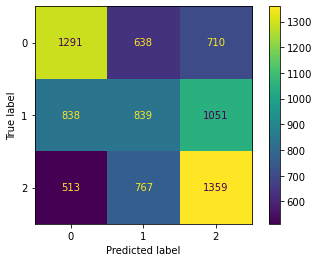

In [113]:
#Confusion Matrix of Random Forest Classifier

y_pred_rfc = rfc_model_pipe.predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)

disp_rfc.plot();

In [114]:
rfc_model_pipe.score(X_test, y_test)

0.43579815138646016

In [115]:
accuracy_score(y_test, y_pred_rfc)

0.43579815138646016

In [116]:
precision_score(y_test, y_pred_rfc, labels=[0], average='micro')

0.4886449659348978

In [117]:
precision_score(y_test, y_pred_rfc, labels=[1], average='micro')

0.3738859180035651

In [118]:
precision_score(y_test, y_pred_rfc, labels=[2], average='micro')

0.4355769230769231

We had the Random Forest Classifier perform well on the train data but the performance drops off considerably with the test data. This is an indication that the model has overfit. We will try to correct for this through the following model tuning steps.

- Modeling Gameplan
1) Train Test Split
2) Baseline Model - Dummy Regressor
3) FSM - LogReg
4) Gridsearch & Pipeline Implementation

Feature Engineering Ideas
- host_has_profile_pic	host_identity_verified	host_response_rate
Use the columns to create a host reliability metric

sum of bedrooms and bathrooms
for each value of bedrooms and bathrooms, do a percentile ranking on the log_price

- create a sum of bedrooms and bathrooms column, along with pricing percentile
- use the above to create a reverse index (low cost, more bedrooms and bathrooms)

-look at histogram of price or log_price, amenities

-feature engineering something with beds & baths?

pricing percentile - standardized column

-good deal, neutral deal, great deal target value
-map out the good deals, bad deals, and neutral deals across the NYC boroughs?